In [ ]:
!pip install xlrd

In [ ]:
!pip install openpyxl

import pathlib

import pandas as pd
import numpy as np
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
import tensorflow as tf

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization

In [ ]:
PY_DATOS_REALES_EST_SA=pd.read_excel("/content/drive/MyDrive/Datos/Copia de 4 Variables. Datos reales estandarizados sin atípicos (z-score).xlsx", sheet_name='Datos sin atipicos', header=0, index_col=0, usecols='A, B, C, D, E')
PY_DATOS_REALES_EST_SA

Días      Área  PY_VC_PCA  Valor_Proyecto
#                                                 
1    0.199969 -0.224328  -0.670771       -0.563421
2    0.199969 -0.224328  -0.670771       -0.545120
3    0.199969 -0.222966  -0.670771       -0.544601
4    0.199969 -0.222966  -0.670771       -0.532932
5    1.478731 -0.182279  -0.670771       -0.532623
..        ...       ...        ...             ...
121 -0.699160 -0.219754  -1.883419       -0.617652
122 -0.659199 -0.223679  -1.883419       -0.604545
123 -0.579276 -0.224410  -1.883419       -0.584883
124 -0.898967 -0.074911  -1.932311       -0.488695
125  0.080085 -0.203695  -0.670771        1.333930

[115 rows x 4 columns]

In [ ]:
PY_DATOS_REALES_EST_SA.describe()

Días        Área   PY_VC_PCA  Valor_Proyecto
count  115.000000  115.000000  115.000000      115.000000
mean    -0.082193   -0.098454   -0.089025       -0.097465
std      0.780387    0.605987    1.861373        0.706249
min     -0.918948   -0.224417   -1.932311       -0.682176
25%     -0.669189   -0.224096   -1.883419       -0.587202
50%     -0.359489   -0.222363   -0.670771       -0.410561
75%      0.219950   -0.203633    0.739387        0.150954
max      3.576699    4.300396    3.524117        2.571424

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, ELU, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy.stats import spearmanr
import random

# Fijar la semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Función personalizada para calcular SSE
def sse(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

# Función personalizada para calcular SAE
def sae(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Función personalizada para calcular el coeficiente de determinación R^2
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Función personalizada para calcular el coeficiente de correlación de Pearson
def pearson_correlation(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    x = y_true - tf.reduce_mean(y_true)
    y = y_pred - tf.reduce_mean(y_pred)
    r_num = tf.reduce_sum(x * y)
    r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
    return r_num / (r_den + tf.keras.backend.epsilon())

# Función para calcular RMSE
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Seleccionar las columnas relevantes para la predicción de 'Valor_Proyecto'
data = PY_DATOS_REALES_EST_SA[['Días', 'Área', 'PY_VC_PCA', 'Valor_Proyecto']]
X = data.drop('Valor_Proyecto', axis=1).values
y = data['Valor_Proyecto'].values

# Dividir los datos en entrenamiento y validación con una semilla fija
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Función que entrena el modelo y devuelve la pérdida final, el historial y el modelo
def train_model_with_params(units_1, units_2, learning_rate):
    model = Sequential([
        Dense(int(units_1), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(units_2), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Mantener el resto del código igual
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9), #---------------------------------
                  loss='mean_squared_error',                                #--------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #-----------------------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                      #-----------------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr, checkpoint],
                        verbose=1)

    return -history.history['val_loss'][-1], history, model

# Función solo para la optimización bayesiana (retorna solo la pérdida)
def train_model_for_optimization(units_1, units_2, learning_rate):

    val_loss, _, _ = train_model_with_params(units_1, units_2, learning_rate)
    return val_loss

# Definir los límites para la optimización
pbounds = {
    'units_1': (5, 100),
    'units_2': (5, 100),
    'learning_rate': (0.0001, 0.01)
}

# Crear una instancia de BayesianOptimization con semilla
optimizer = BayesianOptimization(
    f=train_model_for_optimization,
    pbounds=pbounds,
    random_state=42,  # Fijar la semilla para la optimización bayesiana
    verbose=2
)

# Ejecutar la optimización
optimizer.maximize(init_points=20, n_iter=20) #------------------------ 20

# Recuperar los mejores hiperparámetros
best_params = optimizer.max['params']

# Redondear los valores de las unidades a enteros para las capas
best_params['units_1'] = int(round(best_params['units_1']))
best_params['units_2'] = int(round(best_params['units_2']))

print("Mejores parámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Entrenar el modelo con los mejores hiperparámetros encontrados y obtener el historial y el modelo
val_loss, history, model = train_model_with_params(
    best_params['units_1'],
    best_params['units_2'],
    best_params['learning_rate']
)

|   iter    |  target   | learni... |  units_1  |  units_2  |
-------------------------------------------------------------
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 55/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.1265 - loss: 0.3103 - mae: 0.3635 - mse: 0.2812 - pearson_correlation: -2.2404e-16 - r2_keras: -93.3965 - rmse: 0.8455 - sae: 2497.8843 - sse: 2928.0601
Epoch 55: val_loss did not improve from 0.25734
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - huber_loss: 0.1229 - loss: 0.3026 - mae: 0.3629 - mse: 0.2735 - pearson_correlation: -8.7589e-17 - r2_keras: -76.4048 - rmse: 0.8323 - sae: 1825.0204 - sse: 2121.8186 - val_huber_loss: 0.1427 - val_loss: 0.3321 - val_mae: 0.4029 - val_mse: 0.3031 - val_pearson_correlation: 1.9827e-16 - val_r2_keras: -33.2406 - val_rmse: 0.9529 - val_sae: 361.8415 - val_sse: 480.3313 - learning_rate: 1.0000e-05
Epoch 56/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.1264 - loss: 0.3102 - mae: 0.3632 - mse: 0.2811 - pearson_correlation: 5.2607e-17 - r2_keras: -93.3899 - rmse: 0.8455 - sae: 2497.7705 - sse: 2927.8579
Epoch 56: val_loss did 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8008 - loss: 2.4899 - mae: 1.2047 - mse: 2.4768 - pearson_correlation: -3.7356e-16 - r2_keras: -416.1558 - rmse: 1.7774 - sae: 5486.3711 - sse: 12939.6504
Epoch 1: val_loss improved from inf to 0.79170, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - huber_loss: 0.8006 - loss: 2.4522 - mae: 1.2076 - mse: 2.4390 - pearson_correlation: -3.2395e-16 - r2_keras: -348.1783 - rmse: 1.7803 - sae: 4003.6545 - sse: 9460.1396 - val_huber_loss: 0.3223 - val_loss: 0.7917 - val_mae: 0.6981 - val_mse: 0.7785 - val_pearson_correlation: 1.2386e-16 - val_r2_keras: -25.9605 - val_rmse: 0.8455 - val_sae: 343.2818 - val_sse: 378.2054 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.7638 - loss: 2.3183 - mae: 1.1656 - mse: 2.3051 - pearson_correlation: 3.1685e-16 - r2_keras: -393.2298 - rmse: 1.7279 - sae: 5329.7378 - sse: 12228.5156
Epoch 2: val_loss improved from 0.79170 to 0.78943, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7365 - loss: 1.9457 - mae: 1.1755 - mse: 1.9295 - pearson_correlation: 3.3262e-16 - r2_keras: -184.9318 - rmse: 1.1866 - sae: 3936.6182 - sse: 5767.3711
Epoch 1: val_loss improved from inf to 0.48362, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - huber_loss: 0.5696 - loss: 1.6534 - mae: 1.0508 - mse: 1.6372 - pearson_correlation: 2.2174e-16 - r2_keras: -146.7807 - rmse: 1.1358 - sae: 2831.3967 - sse: 4124.3960 - val_huber_loss: 0.1995 - val_loss: 0.4836 - val_mae: 0.4758 - val_mse: 0.4673 - val_pearson_correlation: -2.3008e-17 - val_r2_keras: -28.1232 - val_rmse: 0.8788 - val_sae: 334.7481 - val_sse: 408.5436 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.4600 - loss: 1.2968 - mae: 0.8214 - mse: 1.2804 - pearson_correlation: 1.0312e-16 - r2_keras: -321.5287 - rmse: 1.5628 - sae: 4783.6025 - sse: 10004.4375
Epoch 2: val_loss did not improve from 0.48362
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.3201 - loss: 0.7956 - mae: 0.6866 - mse: 0.7643 - pearson_correlation: 2.6109e-16 - r2_keras: -173.1933 - rmse: 1.1485 - sae: 3730.4028 - sse: 5403.2568
Epoch 1: val_loss improved from inf to 0.48389, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - huber_loss: 0.2773 - loss: 0.7188 - mae: 0.6586 - mse: 0.6875 - pearson_correlation: 6.6673e-17 - r2_keras: -132.9547 - rmse: 1.0639 - sae: 2677.2361 - sse: 3811.2695 - val_huber_loss: 0.1791 - val_loss: 0.4839 - val_mae: 0.4569 - val_mse: 0.4526 - val_pearson_correlation: -1.1426e-17 - val_r2_keras: -25.0165 - val_rmse: 0.8306 - val_sae: 311.7844 - val_sse: 364.9616 - learning_rate: 0.0082
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2139 - loss: 0.5108 - mae: 0.5254 - mse: 0.4795 - pearson_correlation: 1.7322e-16 - r2_keras: -79.3447 - rmse: 0.7800 - sae: 2495.2324 - sse: 2492.1914
Epoch 2: val_loss improved from 0.48389 to 0.42785, saving m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7640 - loss: 2.0512 - mae: 1.2096 - mse: 1.9816 - pearson_correlation: 3.0372e-16 - r2_keras: -180.1893 - rmse: 1.1714 - sae: 4004.6138 - sse: 5620.2651
Epoch 1: val_loss improved from inf to 0.97936, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - huber_loss: 0.7490 - loss: 2.0396 - mae: 1.1923 - mse: 1.9701 - pearson_correlation: 2.5539e-16 - r2_keras: -148.3701 - rmse: 1.1584 - sae: 2906.4456 - sse: 4082.0554 - val_huber_loss: 0.3799 - val_loss: 0.9794 - val_mae: 0.7784 - val_mse: 0.9098 - val_pearson_correlation: -1.8357e-16 - val_r2_keras: -24.7349 - val_rmse: 0.8261 - val_sae: 351.8258 - val_sse: 361.0124 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.6089 - loss: 1.5451 - mae: 1.0359 - mse: 1.4756 - pearson_correlation: 2.3605e-17 - r2_keras: -131.9708 - rmse: 1.0035 - sae: 3332.3950 - sse: 4124.5869
Epoch 2: val_loss did not improve from 0.97936
2/2 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - huber_loss: 0.4333 - loss: 1.2585 - mae: 0.7432 - mse: 1.2058 - pearson_correlation: 2.2782e-16 - r2_keras: -176.8073 - rmse: 1.1604 - sae: 3356.1670 - sse: 5515.3608
Epoch 1: val_loss improved from inf to 0.43171, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - huber_loss: 0.4313 - loss: 1.2338 - mae: 0.7347 - mse: 1.1811 - pearson_correlation: 5.5836e-18 - r2_keras: -144.7836 - rmse: 1.1422 - sae: 2452.1321 - sse: 3996.4958 - val_huber_loss: 0.1678 - val_loss: 0.4317 - val_mae: 0.4552 - val_mse: 0.3790 - val_pearson_correlation: -2.5174e-17 - val_r2_keras: -27.2128 - val_rmse: 0.8650 - val_sae: 343.2118 - val_sse: 395.7723 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - huber_loss: 0.3910 - loss: 1.1023 - mae: 0.7043 - mse: 1.0496 - pearson_correlation: -3.9571e-16 - r2_keras: -156.3304 - rmse: 1.0915 - sae: 3180.6396 - sse: 4880.1914
Epoch 2: val_loss improved from 0.43171 to 0.42472, sa

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8263 - loss: 2.3021 - mae: 1.2641 - mse: 2.2661 - pearson_correlation: 1.2025e-15 - r2_keras: -212.7594 - rmse: 1.2723 - sae: 4220.9551 - sse: 6630.5483
Epoch 1: val_loss improved from inf to 1.49672, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - huber_loss: 0.7796 - loss: 2.2186 - mae: 1.2293 - mse: 2.1826 - pearson_correlation: 8.1832e-16 - r2_keras: -170.5118 - rmse: 1.2285 - sae: 3048.3376 - sse: 4760.6011 - val_huber_loss: 0.5385 - val_loss: 1.4967 - val_mae: 0.9623 - val_mse: 1.4607 - val_pearson_correlation: 1.2603e-16 - val_r2_keras: -35.2451 - val_rmse: 0.9804 - val_sae: 403.8888 - val_sse: 508.4500 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.7815 - loss: 2.1395 - mae: 1.2172 - mse: 2.1035 - pearson_correlation: 1.3551e-16 - r2_keras: -197.5336 - rmse: 1.2262 - sae: 4054.2109 - sse: 6158.2632
Epoch 2: val_loss did not improve from 1.49672
2/2 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.2575 - loss: 0.6193 - mae: 0.6213 - mse: 0.5792 - pearson_correlation: -6.9432e-16 - r2_keras: -69.7482 - rmse: 0.7320 - sae: 2441.8655 - sse: 2194.5200
Epoch 1: val_loss improved from inf to 0.82386, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - huber_loss: 0.2852 - loss: 0.6470 - mae: 0.6365 - mse: 0.6068 - pearson_correlation: -3.2668e-16 - r2_keras: -76.1231 - rmse: 0.8745 - sae: 1868.2234 - sse: 1814.4174 - val_huber_loss: 0.3183 - val_loss: 0.8239 - val_mae: 0.6885 - val_mse: 0.7837 - val_pearson_correlation: -1.6676e-16 - val_r2_keras: -26.9831 - val_rmse: 0.8614 - val_sae: 341.8054 - val_sse: 392.5497 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - huber_loss: 0.2753 - loss: 0.6643 - mae: 0.5756 - mse: 0.6242 - pearson_correlation: -3.5578e-16 - r2_keras: -155.0045 - rmse: 1.0869 - sae: 3120.5483 - sse: 4839.0649
Epoch 2: val_loss improved from 0.82386 to 0.62002, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.3055 - loss: 0.8337 - mae: 0.6200 - mse: 0.7631 - pearson_correlation: -2.8613e-16 - r2_keras: -212.1553 - rmse: 1.2705 - sae: 3802.4004 - sse: 6611.8101
Epoch 1: val_loss improved from inf to 0.78359, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - huber_loss: 0.2795 - loss: 0.7742 - mae: 0.5993 - mse: 0.7036 - pearson_correlation: -2.9515e-16 - r2_keras: -155.4550 - rmse: 1.1145 - sae: 2697.7271 - sse: 4576.2168 - val_huber_loss: 0.2956 - val_loss: 0.7836 - val_mae: 0.6469 - val_mse: 0.7130 - val_pearson_correlation: 5.5259e-17 - val_r2_keras: -23.1016 - val_rmse: 0.7995 - val_sae: 321.3646 - val_sse: 338.1003 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.2620 - loss: 0.7459 - mae: 0.6256 - mse: 0.6752 - pearson_correlation: -2.3767e-16 - r2_keras: -96.0579 - rmse: 0.8573 - sae: 2730.8638 - sse: 3010.6147
Epoch 2: val_loss improved from 0.78359 to 0.51214, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.2610 - loss: 0.7882 - mae: 0.5796 - mse: 0.7014 - pearson_correlation: -5.3033e-17 - r2_keras: -154.2074 - rmse: 1.0841 - sae: 2982.2661 - sse: 4814.3379
Epoch 1: val_loss improved from inf to 0.64059, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - huber_loss: 0.2845 - loss: 0.8449 - mae: 0.5988 - mse: 0.7580 - pearson_correlation: -6.8316e-17 - r2_keras: -128.6987 - rmse: 1.0844 - sae: 2185.7666 - sse: 3517.2036 - val_huber_loss: 0.2375 - val_loss: 0.6406 - val_mae: 0.5858 - val_mse: 0.5537 - val_pearson_correlation: -2.2422e-16 - val_r2_keras: -23.8396 - val_rmse: 0.8116 - val_sae: 324.4141 - val_sse: 348.4525 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.2386 - loss: 0.7179 - mae: 0.5362 - mse: 0.6310 - pearson_correlation: 4.6646e-17 - r2_keras: -148.3015 - rmse: 1.0633 - sae: 2932.0134 - sse: 4631.1465
Epoch 2: val_loss improved from 0.64059 to 0.63736, s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7706 - loss: 1.9325 - mae: 1.2349 - mse: 1.8925 - pearson_correlation: 3.1649e-16 - r2_keras: -220.3151 - rmse: 1.2946 - sae: 4438.7563 - sse: 6864.9180
Epoch 1: val_loss improved from inf to 0.71144, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - huber_loss: 0.8074 - loss: 2.0790 - mae: 1.2500 - mse: 2.0390 - pearson_correlation: -5.1197e-18 - r2_keras: -223.3274 - rmse: 1.4819 - sae: 3361.7329 - sse: 5477.2910 - val_huber_loss: 0.2899 - val_loss: 0.7114 - val_mae: 0.6138 - val_mse: 0.6708 - val_pearson_correlation: 1.0552e-16 - val_r2_keras: -59.0536 - val_rmse: 1.2619 - val_sae: 520.3867 - val_sse: 842.4389 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.5741 - loss: 1.5102 - mae: 0.9577 - mse: 1.4695 - pearson_correlation: -1.6391e-16 - r2_keras: -329.7601 - rmse: 1.5827 - sae: 5047.0996 - sse: 10259.7637
Epoch 2: val_loss did not improve from 0.71144
2/2 ━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4433 - loss: 1.3912 - mae: 0.7014 - mse: 1.3297 - pearson_correlation: 2.3364e-16 - r2_keras: -213.6268 - rmse: 1.2749 - sae: 3531.2271 - sse: 6657.4561
Epoch 1: val_loss improved from inf to 0.59343, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - huber_loss: 0.4586 - loss: 1.3810 - mae: 0.7172 - mse: 1.3195 - pearson_correlation: 2.9544e-16 - r2_keras: -171.6678 - rmse: 1.2340 - sae: 2573.5886 - sse: 4785.3169 - val_huber_loss: 0.2386 - val_loss: 0.5934 - val_mae: 0.6075 - val_mse: 0.5319 - val_pearson_correlation: -1.7912e-16 - val_r2_keras: -25.7101 - val_rmse: 0.8416 - val_sae: 357.8152 - val_sse: 374.6922 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - huber_loss: 0.4131 - loss: 1.2694 - mae: 0.6686 - mse: 1.2078 - pearson_correlation: -2.4169e-16 - r2_keras: -197.5825 - rmse: 1.2263 - sae: 3416.1013 - sse: 6159.7808
Epoch 2: val_loss did not improve from 0.59343
2/2 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.3106 - loss: 4.5357 - mae: 1.7692 - mse: 4.4772 - pearson_correlation: -5.1044e-17 - r2_keras: -418.0728 - rmse: 1.7815 - sae: 5876.5693 - sse: 12999.1152
Epoch 1: val_loss improved from inf to 0.39892, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - huber_loss: 1.0137 - loss: 3.8222 - mae: 1.5624 - mse: 3.7637 - pearson_correlation: 1.0653e-17 - r2_keras: -314.6282 - rmse: 1.6128 - sae: 4175.5630 - sse: 9091.2471 - val_huber_loss: 0.1656 - val_loss: 0.3989 - val_mae: 0.4661 - val_mse: 0.3397 - val_pearson_correlation: 1.8651e-16 - val_r2_keras: -39.5166 - val_rmse: 1.0365 - val_sae: 422.5930 - val_sse: 568.3715 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.5172 - loss: 1.4845 - mae: 0.9476 - mse: 1.4253 - pearson_correlation: -8.2054e-17 - r2_keras: -350.8768 - rmse: 1.6324 - sae: 5165.5503 - sse: 10914.7793
Epoch 2: val_loss did not improve from 0.39892
2/2 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.5648 - loss: 1.4062 - mae: 0.9920 - mse: 1.3982 - pearson_correlation: 2.9310e-16 - r2_keras: -129.8903 - rmse: 0.9956 - sae: 3201.7966 - sse: 4060.0540
Epoch 1: val_loss improved from inf to 0.80950, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - huber_loss: 0.5504 - loss: 1.3792 - mae: 0.9775 - mse: 1.3712 - pearson_correlation: 3.3383e-16 - r2_keras: -105.9847 - rmse: 0.9774 - sae: 2327.4285 - sse: 2938.0720 - val_huber_loss: 0.3547 - val_loss: 0.8095 - val_mae: 0.7460 - val_mse: 0.8015 - val_pearson_correlation: 3.0290e-17 - val_r2_keras: -25.2848 - val_rmse: 0.8349 - val_sae: 364.5005 - val_sse: 368.7265 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.5634 - loss: 1.4019 - mae: 0.9903 - mse: 1.3939 - pearson_correlation: -1.1979e-16 - r2_keras: -129.5324 - rmse: 0.9942 - sae: 3196.0969 - sse: 4048.9504
Epoch 2: val_loss did not improve from 0.80950
2/2 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - huber_loss: 1.4197 - loss: 6.1239 - mae: 1.8150 - mse: 6.1100 - pearson_correlation: 2.9370e-16 - r2_keras: -751.4357 - rmse: 2.3871 - sae: 7332.8486 - sse: 23339.6133
Epoch 1: val_loss improved from inf to 0.89416, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - huber_loss: 1.3159 - loss: 5.6521 - mae: 1.7574 - mse: 5.6381 - pearson_correlation: 2.3430e-16 - r2_keras: -582.5410 - rmse: 2.2306 - sae: 5308.4985 - sse: 16520.6328 - val_huber_loss: 0.3732 - val_loss: 0.8942 - val_mae: 0.6905 - val_mse: 0.8801 - val_pearson_correlation: 2.0790e-16 - val_r2_keras: -51.4921 - val_rmse: 1.1798 - val_sae: 493.6227 - val_sse: 736.3643 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - huber_loss: 0.7771 - loss: 2.3799 - mae: 1.1574 - mse: 2.3659 - pearson_correlation: 4.0635e-16 - r2_keras: -289.3092 - rmse: 1.4827 - sae: 4659.5825 - sse: 9005.0293
Epoch 2: val_loss improved from 0.89416 to 0.56602, saving

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.3314 - loss: 1.1306 - mae: 0.6103 - mse: 1.0476 - pearson_correlation: 3.8549e-16 - r2_keras: -210.1709 - rmse: 1.2646 - sae: 3247.1433 - sse: 6550.2583
Epoch 1: val_loss improved from inf to 0.62198, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - huber_loss: 0.3142 - loss: 1.0502 - mae: 0.6092 - mse: 0.9672 - pearson_correlation: 1.5743e-16 - r2_keras: -162.7735 - rmse: 1.1817 - sae: 2371.2588 - sse: 4636.5459 - val_huber_loss: 0.2226 - val_loss: 0.6220 - val_mae: 0.5488 - val_mse: 0.5390 - val_pearson_correlation: -2.4516e-16 - val_r2_keras: -23.1833 - val_rmse: 0.8008 - val_sae: 318.5379 - val_sse: 339.2461 - learning_rate: 0.0021
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - huber_loss: 0.2391 - loss: 0.6187 - mae: 0.5308 - mse: 0.5357 - pearson_correlation: -2.4225e-16 - r2_keras: -108.4208 - rmse: 0.9103 - sae: 2888.5076 - sse: 3394.0977
Epoch 2: val_loss did not improve from 0.62198
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 1.2459 - loss: 4.1126 - mae: 1.7119 - mse: 4.0970 - pearson_correlation: 2.1485e-16 - r2_keras: -395.8807 - rmse: 1.7337 - sae: 5775.6025 - sse: 12310.7422
Epoch 1: val_loss improved from inf to 1.49873, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - huber_loss: 1.2070 - loss: 4.0536 - mae: 1.6807 - mse: 4.0380 - pearson_correlation: -1.4125e-17 - r2_keras: -323.1047 - rmse: 1.7006 - sae: 4190.3628 - sse: 8905.3047 - val_huber_loss: 0.5855 - val_loss: 1.4987 - val_mae: 0.9919 - val_mse: 1.4831 - val_pearson_correlation: -2.5639e-16 - val_r2_keras: -35.0084 - val_rmse: 0.9772 - val_sae: 398.2018 - val_sse: 505.1304 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 1.2244 - loss: 4.0072 - mae: 1.6905 - mse: 3.9917 - pearson_correlation: -3.5329e-16 - r2_keras: -385.7461 - rmse: 1.7114 - sae: 5708.0908 - sse: 11996.3799
Epoch 2: val_loss did not improve from 1.49873
2/2 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4791 - loss: 1.2207 - mae: 0.9075 - mse: 1.1623 - pearson_correlation: 5.6200e-16 - r2_keras: -95.6933 - rmse: 0.8557 - sae: 2862.1367 - sse: 2999.3052
Epoch 1: val_loss improved from inf to 1.02748, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - huber_loss: 0.4798 - loss: 1.2044 - mae: 0.9056 - mse: 1.1460 - pearson_correlation: 4.9875e-16 - r2_keras: -79.4989 - rmse: 0.8533 - sae: 2090.4443 - sse: 2187.6479 - val_huber_loss: 0.3795 - val_loss: 1.0275 - val_mae: 0.7779 - val_mse: 0.9691 - val_pearson_correlation: -8.8657e-17 - val_r2_keras: -24.6701 - val_rmse: 0.8251 - val_sae: 335.1620 - val_sse: 360.1030 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.4395 - loss: 1.1151 - mae: 0.8609 - mse: 1.0566 - pearson_correlation: 2.7578e-16 - r2_keras: -89.3911 - rmse: 0.8274 - sae: 2770.3440 - sse: 2803.8188
Epoch 2: val_loss did not improve from 1.02748
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.8545 - loss: 2.5278 - mae: 1.2964 - mse: 2.4611 - pearson_correlation: -1.3125e-16 - r2_keras: -218.2182 - rmse: 1.2885 - sae: 4222.5264 - sse: 6799.8740
Epoch 1: val_loss improved from inf to 0.40868, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - huber_loss: 0.6757 - loss: 2.1717 - mae: 1.1565 - mse: 2.1051 - pearson_correlation: -1.1464e-16 - r2_keras: -167.2142 - rmse: 1.1907 - sae: 3013.5945 - sse: 4792.1167 - val_huber_loss: 0.1599 - val_loss: 0.4087 - val_mae: 0.4457 - val_mse: 0.3419 - val_pearson_correlation: 2.5505e-16 - val_r2_keras: -29.6525 - val_rmse: 0.9016 - val_sae: 361.9736 - val_sse: 429.9962 - learning_rate: 0.0038
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - huber_loss: 0.2442 - loss: 0.6402 - mae: 0.5026 - mse: 0.5734 - pearson_correlation: -5.2044e-16 - r2_keras: -188.5076 - rmse: 1.1980 - sae: 3561.6187 - sse: 5878.2896
Epoch 2: val_loss improved from 0.40868 to 0.37574, savi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.7371 - loss: 2.1558 - mae: 1.2064 - mse: 2.1143 - pearson_correlation: 4.3180e-16 - r2_keras: -281.6466 - rmse: 1.4630 - sae: 4754.0020 - sse: 8767.3447
Epoch 1: val_loss improved from inf to 0.77318, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - huber_loss: 0.7093 - loss: 2.0718 - mae: 1.1773 - mse: 2.0303 - pearson_correlation: 4.4986e-16 - r2_keras: -232.2795 - rmse: 1.4483 - sae: 3475.5762 - sse: 6370.9702 - val_huber_loss: 0.3351 - val_loss: 0.7732 - val_mae: 0.6806 - val_mse: 0.7302 - val_pearson_correlation: -7.7796e-17 - val_r2_keras: -51.6876 - val_rmse: 1.1820 - val_sae: 497.2421 - val_sse: 739.1074 - learning_rate: 0.0100
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - huber_loss: 0.2687 - loss: 0.7088 - mae: 0.6068 - mse: 0.6658 - pearson_correlation: 2.1305e-16 - r2_keras: -101.6842 - rmse: 0.8818 - sae: 2622.5752 - sse: 3185.1353
Epoch 2: val_loss improved from 0.77318 to 0.52815, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - huber_loss: 0.4426 - loss: 1.0100 - mae: 0.8738 - mse: 0.9959 - pearson_correlation: -4.6055e-16 - r2_keras: -125.5109 - rmse: 0.9788 - sae: 3384.5024 - sse: 3924.2112
Epoch 1: val_loss improved from inf to 0.69211, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - huber_loss: 0.4080 - loss: 0.9484 - mae: 0.8522 - mse: 0.9342 - pearson_correlation: -3.2599e-16 - r2_keras: -102.1129 - rmse: 0.9585 - sae: 2458.2188 - sse: 2836.3408 - val_huber_loss: 0.2806 - val_loss: 0.6921 - val_mae: 0.6366 - val_mse: 0.6780 - val_pearson_correlation: -4.2406e-16 - val_r2_keras: -23.8964 - val_rmse: 0.8125 - val_sae: 334.3829 - val_sse: 349.2498 - learning_rate: 1.0000e-04
Epoch 2/1000
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - huber_loss: 0.4220 - loss: 0.9558 - mae: 0.8482 - mse: 0.9417 - pearson_correlation: -1.4427e-16 - r2_keras: -121.9962 - rmse: 0.9651 - sae: 3325.0854 - sse: 3815.1895
Epoch 2: val_loss did not improve from 0.69211
2/2 ━

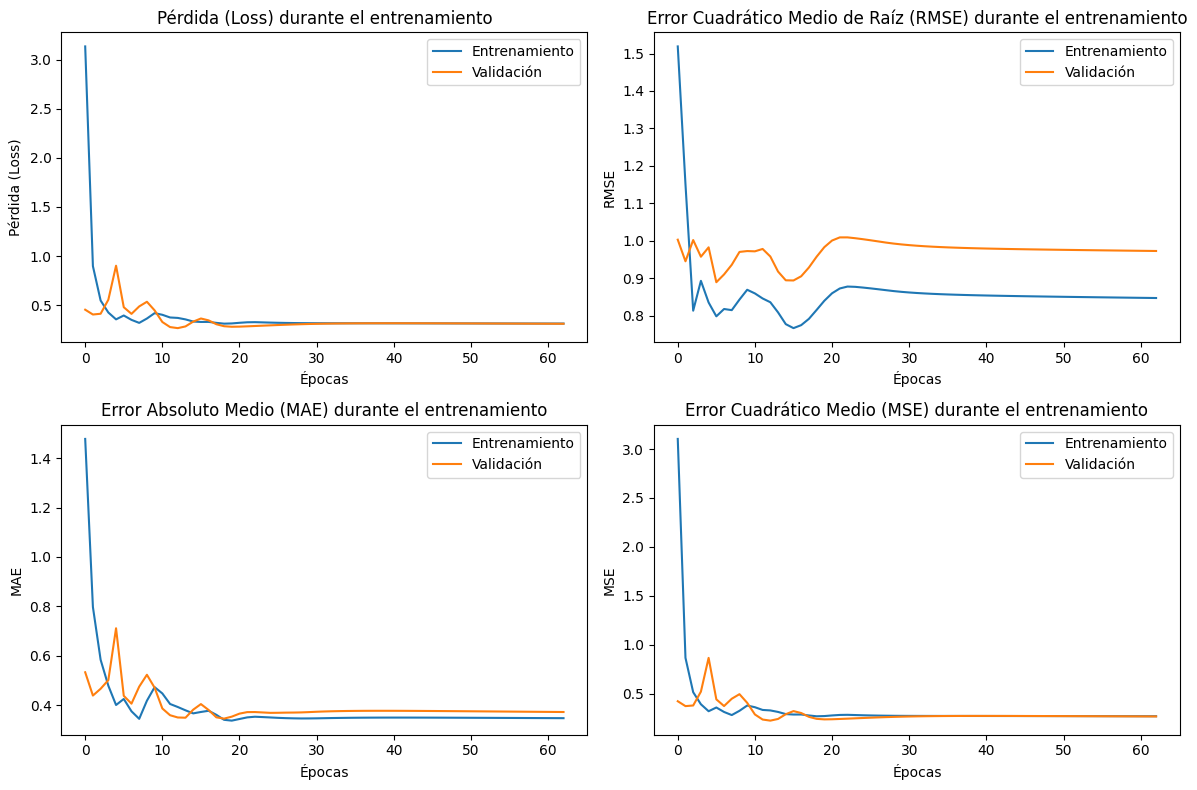

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


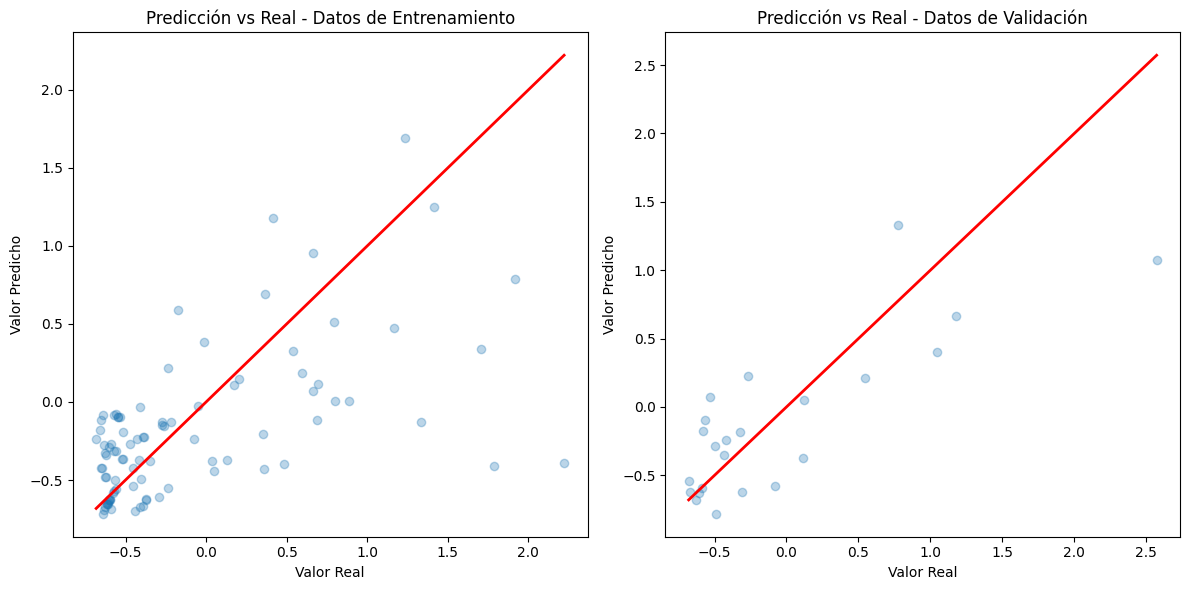


Métricas de entrenamiento:
MSE: 0.3125108146721665
RMSE: 0.5590266672281087
MAE: 0.3663667686997371
R^2: 0.3280243393281238
Correlación de Pearson: -1.2288957955001297e-16
Correlación de Spearman: 0.560142104712467
SSE: 5794.324021028475
SAE: 5000.266034863507
Media del error: 0.0848287591111456
Desviación estándar del error: 0.8230362553890945
Huber Loss (Entrenamiento): 0.12163493037223816

Métricas de validación:
MSE: 0.22381525799379065
RMSE: 0.4730911730245986
MAE: 0.35076950430803416
R^2: 0.6330402254334799
Correlación de Pearson: 5.603153472778692e-17
Correlación de Spearman: 0.6867588932806324
SSE: 485.6453743041317
SAE: 360.82785427464694
Media del error: 0.06260969138075331
Desviación estándar del error: 0.95609843236736
Huber Loss (Validación): 0.1280718445777893
El punto de convergencia (mejor epoch): 13


In [9]:
# Graficar las curvas de aprendizaje (entrenamiento y validación)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['rmse'], label='Entrenamiento')
plt.plot(history.history['val_rmse'], label='Validación')
plt.title('Error Cuadrático Medio de Raíz (RMSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Validación')
plt.title('Error Cuadrático Medio (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar los datos entrenados vs reales y validados vs reales
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

# Gráfico de datos de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

# Gráfico de datos de validación
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Datos de Validación')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Función para calcular la media y desviación estándar
def calcular_media_desviacion(y_true, y_pred):
    diferencia = y_true - y_pred
    media = np.mean(diferencia)
    desviacion = np.std(diferencia)
    return media, desviacion

# Evaluar el modelo final en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
pearson_train = pearson_correlation(y_train, y_train_pred).numpy()
spearman_train, _ = spearmanr(y_train, y_train_pred)  # Correlación de Spearman
sse_train = np.sum((y_train - y_train_pred) ** 2)
sae_train = np.sum(np.abs(y_train - y_train_pred))
media_train, desviacion_train = calcular_media_desviacion(y_train, y_train_pred)
huber_loss_train = history.history['huber_loss'][-1]

print("\nMétricas de entrenamiento:")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")
print(f"R^2: {r2_train}")
print(f"Correlación de Pearson: {pearson_train}")
print(f"Correlación de Spearman: {spearman_train}")
print(f"SSE: {sse_train}")
print(f"SAE: {sae_train}")
print(f"Media del error: {media_train}")
print(f"Desviación estándar del error: {desviacion_train}")
print(f"Huber Loss (Entrenamiento): {huber_loss_train}")

# Evaluar el modelo final en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
pearson_val = pearson_correlation(y_val, y_val_pred).numpy()
spearman_val, _ = spearmanr(y_val, y_val_pred)  # Correlación de Spearman
sse_val = np.sum((y_val - y_val_pred) ** 2)
sae_val = np.sum(np.abs(y_val - y_val_pred))
media_val, desviacion_val = calcular_media_desviacion(y_val, y_val_pred)
huber_loss_val = history.history['val_huber_loss'][-1]

print("\nMétricas de validación:")
print(f"MSE: {mse_val}")
print(f"RMSE: {rmse_val}")
print(f"MAE: {mae_val}")
print(f"R^2: {r2_val}")
print(f"Correlación de Pearson: {pearson_val}")
print(f"Correlación de Spearman: {spearman_val}")
print(f"SSE: {sse_val}")
print(f"SAE: {sae_val}")
print(f"Media del error: {media_val}")
print(f"Desviación estándar del error: {desviacion_val}")
print(f"Huber Loss (Validación): {huber_loss_val}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


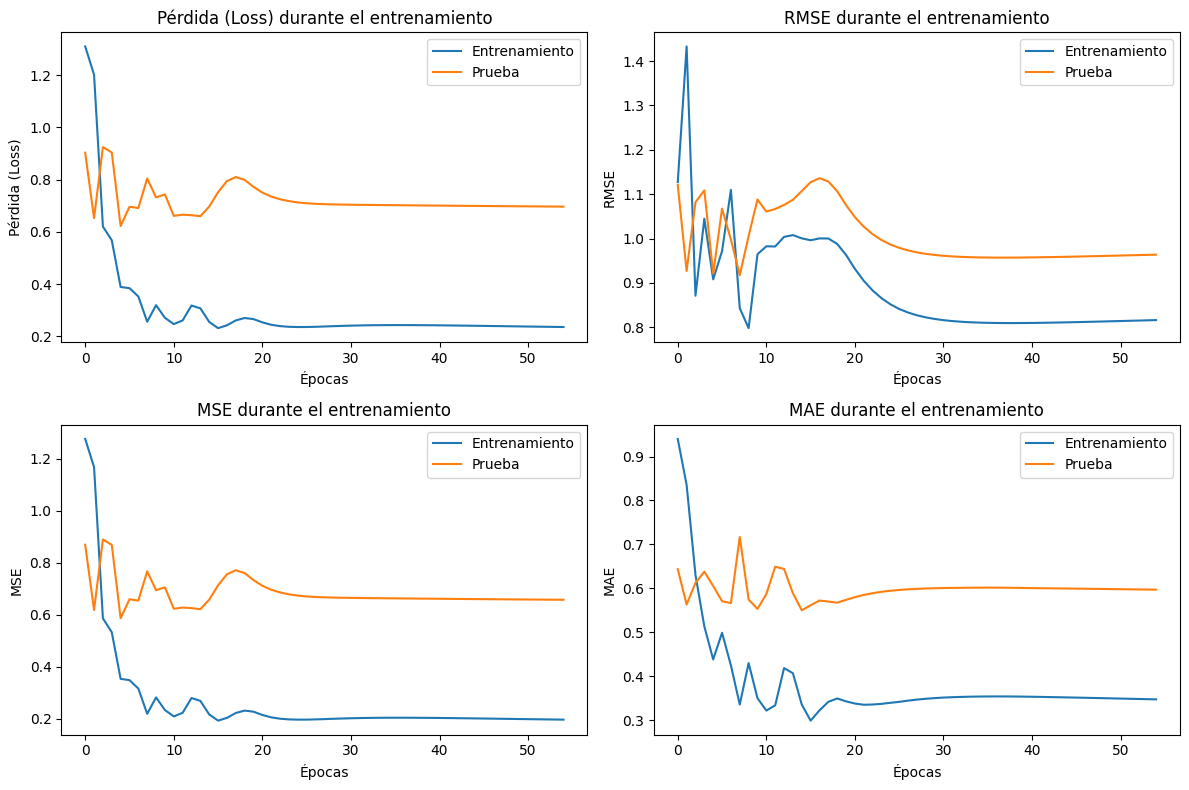

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


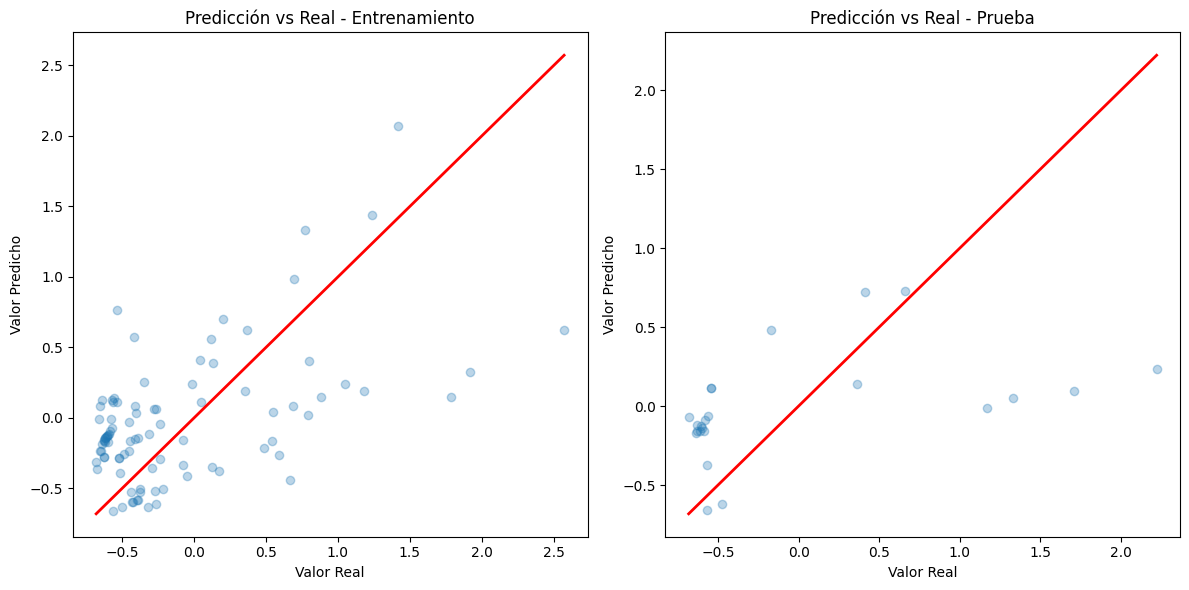

Simulación de cross_val_score (MSE): 0.30533389287675494 ± 0.15395546180964098
Simulación de cross_val_score (RMSE): 0.5367702442459634 ± 0.13119297911429426
Simulación de cross_val_score (MAE): 0.41789948453301695 ± 0.10480189209633134
SSE promedio: 366.9006018543838
SAE promedio: 338.78226057186623
R^2 promedio: 0.3738956177331284, Desviación estándar: 0.18263016223987813
Correlación de Pearson promedio: 2.987394317746495e-17, Desviación estándar: 2.1642563791685858e-16
Correlación de Spearman promedio: 0.6208034416126168, Desviación estándar: 0.14291696917849464
Huber Loss promedio: 0.12526539266109465, Desviación estándar: 0.043587015467318656
El punto de convergencia (mejor epoch): 5


In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import numpy as np

# Definir el número de pliegues (k) para la validación cruzada
k = 5

# Crear un objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Inicializar listas para almacenar las métricas en cada pliegue
mse_scores = []
mae_scores = []
sse_scores = []
sae_scores = []
r2_scores = []
pearson_scores = []
rmse_scores = []
spearman_scores = []
huber_loss_scores = []

# Iterar sobre los pliegues
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo con los datos del pliegue actual
    model = Sequential([
        Dense(int(best_params['units_1']), input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(int(best_params['units_2']), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Activation('elu'),  # Cambiar LeakyReLU por relu
        BatchNormalization(momentum=0.8),

        Dense(1, activation='linear')
    ])

    # Función personalizada para calcular SSE
    def sse(y_true, y_pred):
        return tf.reduce_sum(tf.square(y_true - y_pred))

    # Función personalizada para calcular SAE
    def sae(y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))

    # Función personalizada para calcular el coeficiente de determinación R^2
    def r2_keras(y_true, y_pred):
        ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

    # Función personalizada para calcular el coeficiente de correlación de Pearson
    def pearson_correlation(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)  # Cast y_true to float64
        y_pred = tf.cast(y_pred, tf.float64)  # Cast y_pred to float64
        x = y_true - tf.reduce_mean(y_true)
        y = y_pred - tf.reduce_mean(y_pred)
        r_num = tf.reduce_sum(x * y)
        r_den = tf.sqrt(tf.reduce_sum(tf.square(x)) * tf.reduce_sum(tf.square(y)))
        return r_num / (r_den + tf.keras.backend.epsilon())

    # Función para calcular RMSE
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    model.compile(optimizer=tf.keras.optimizers.SGD(best_params['learning_rate'], momentum=0.9), #-----------------------------
                  loss='mean_squared_error',              #-----------------------------------------
                  metrics=['mae', 'mse', rmse, sse, sae, r2_keras, pearson_correlation, tf.keras.losses.Huber(name='huber_loss')])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #--------------------50
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=1000,                              #--------------------1000
                        batch_size=64,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)

    # Predecir con el modelo en el conjunto de validación
    y_pred = model.predict(X_val)

    # Calcular las métricas de error
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    sse = np.sum((y_val - y_pred) ** 2)
    sae = np.sum(np.abs(y_val - y_pred))
    r2 = r2_score(y_val, y_pred)
    pearson = pearson_correlation(y_val, y_pred).numpy()
    spearman, _ = spearmanr(y_val, y_pred)
    huber_loss = history.history['huber_loss'][-1]

    # Almacenar las métricas en las listas
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    sse_scores.append(sse)
    sae_scores.append(sae)
    r2_scores.append(r2)
    pearson_scores.append(pearson)
    spearman_scores.append(spearman)
    huber_loss_scores.append(huber_loss)

import matplotlib.pyplot as plt

# Graficar las curvas de aprendizaje (pérdida, huber_loss, mse, mae)
plt.figure(figsize=(12, 8))

# Pérdida (Loss)
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Pérdida (Loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()

# Huber Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['rmse'], label='Entrenamiento')
plt.plot(history.history['val_rmse'], label='Prueba')
plt.title('RMSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

# MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Entrenamiento')
plt.plot(history.history['val_mse'], label='Prueba')
plt.title('MSE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

# MAE
plt.subplot(2, 2, 4)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Prueba')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Gráfico de predicciones en los datos de entrenamiento
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Predicción vs Real - Entrenamiento')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r', lw=2)
plt.title('Predicción vs Real - Prueba')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')

plt.tight_layout()
plt.show()

# Calcular estadísticas de las métricas
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
mae_mean = np.mean(mae_scores)
mae_std = np.std(mae_scores)
sse_mean = np.mean(sse_scores)
sae_mean = np.mean(sae_scores)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
pearson_mean = np.mean(pearson_scores)
pearson_std = np.std(pearson_scores)
spearman_mean = np.mean(spearman_scores)
spearman_std = np.std(spearman_scores)
huber_loss_mean = np.mean(huber_loss_scores)
huber_loss_std = np.std(huber_loss_scores)

# Simular cross_val_score al imprimir el promedio de las métricas
print(f"Simulación de cross_val_score (MSE): {mse_mean} ± {mse_std}")
print(f"Simulación de cross_val_score (RMSE): {rmse_mean} ± {rmse_std}")
print(f"Simulación de cross_val_score (MAE): {mae_mean} ± {mae_std}")
print(f"SSE promedio: {sse_mean}")
print(f"SAE promedio: {sae_mean}")
print(f"R^2 promedio: {r2_mean}, Desviación estándar: {r2_std}")
print(f"Correlación de Pearson promedio: {pearson_mean}, Desviación estándar: {pearson_std}")
print(f"Correlación de Spearman promedio: {spearman_mean}, Desviación estándar: {spearman_std}")
print(f"Huber Loss promedio: {huber_loss_mean}, Desviación estándar: {huber_loss_std}")

# Imprimir la época en la que se alcanzó la mejor validación
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"El punto de convergencia (mejor epoch): {best_epoch}")